## Notebook Setup

In [ ]:
!pip install open3d

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'UnseenObjectClustering'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


sys.path.append("/content/" + GOOGLE_DRIVE_PATH)
sys.path.append("/content/" + GOOGLE_DRIVE_PATH + "/lib")
# sys.path.append(GOOGLE_DRIVE_PATH + "/lib/fcn")

['DrewLAB.ipynb', 'result_2018-08-23-11-34-44.pcd', 'README.md', 'LICENSE.md', '.gitignore', 'experiments', 'lib', '.git', 'tools', 'ros', 'data', 'requirement.txt', 'TOD.rar', 'output', 'python-pcl-0.2.0', 'bunny.pcd', 'bunny.pcd.1', 'TrainOnNewImages.ipynb', 'zero_waste.ipynb', 'ZeroWasteTestingSuite.ipynb', 'TestingSuite.ipynb']


In [5]:
sys.path.append("/content/" + GOOGLE_DRIVE_PATH)
sys.path.append("/content/" + GOOGLE_DRIVE_PATH + "/lib")
%cd "/content/drive/My Drive/UnseenObjectClustering"

/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering


In [6]:
!pip uninstall -y pyyaml
!pip install transforms3d pillow IPython matplotlib easydict future scipy imageio
!pip uninstall -y pcl
!pip install pyyaml==5.4.1

Found existing installation: PyYAML 5.4.1
Uninstalling PyYAML-5.4.1:
  Successfully uninstalled PyYAML-5.4.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PyYAML-5.4.1-cp39-cp39-manylinux1_x86_64.whl (630 kB)


## Imports

In [7]:
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data

import argparse
import pprint
import time, os, sys
import os.path as osp
import numpy as np
import cv2
import scipy.io
import glob
import json

#import _init_paths
from fcn.test_dataset import test_sample
from fcn.config import cfg, cfg_from_file, get_output_dir
import networks
from utils.blob import pad_im
from utils import mask as util_





## Helper Functions

In [8]:
def process_label(foreground_labels):
  # map forground labels to actual numbers ya know?
  unique_nonnegative_indices = np.unique(foreground_labels)
  mapped_labels = foreground_labels.copy()
  for k in range(unique_nonnegative_indices.shape[0]):
      mapped_labels[foreground_labels == unique_nonnegative_indices[k]] = k
      
  foreground_labels = mapped_labels
  return foreground_labels

In [9]:
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Test a PoseCNN network')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU id to use',
                        default=0, type=int)
    parser.add_argument('--pretrained', dest='pretrained',
                        help='initialize with pretrained checkpoint',
                        default=None, type=str)
    parser.add_argument('--pretrained_crop', dest='pretrained_crop',
                        help='initialize with pretrained checkpoint for crops',
                        default=None, type=str)
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file', default=None, type=str)
    parser.add_argument('--dataset', dest='dataset_name',
                        help='dataset to train on',
                        default='shapenet_scene_train', type=str)
    parser.add_argument('--depth', dest='depth_name',
                        help='depth image pattern',
                        default='*depth.png', type=str)
    parser.add_argument('--color', dest='color_name',
                        help='color image pattern',
                        default='*color.png', type=str)
    
    parser.add_argument('--gt', dest='gt_name',
                    help='gt image pattern',
                    default='*gt.png', type=str)

    parser.add_argument('--imgdir', dest='imgdir',
                        help='path of the directory with the test images',
                        default=None, type=str)
    parser.add_argument('--rand', dest='randomize',
                        help='randomize (do not use a fixed seed)',
                        action='store_true')
    parser.add_argument('--network', dest='network_name',
                        help='name of the network',
                        default=None, type=str)
    parser.add_argument('--image_path', dest='image_path',
                        help='path to images', default=None, type=str)

    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)

    args = parser.parse_args()
    return args


# save data
def save_data(file_rgb, out_label_refined, roi, features_crop):

    # meta data
    '''
    meta = {'roi': roi, 'features': features_crop.cpu().detach().numpy(), 'labels': out_label_refined.cpu().detach().numpy()}
    filename = file_rgb[:-9] + 'meta.mat'
    scipy.io.savemat(filename, meta, do_compression=True)
    print('save data to {}'.format(filename))
    '''

    # segmentation labels
    label_save = out_label_refined.cpu().detach().numpy()[0]
    label_save = np.clip(label_save, 0, 1) * 255
    label_save = label_save.astype(np.uint8)
    filename = file_rgb[:-4] + '-label.png'
    cv2.imwrite(filename, label_save)
    print('save data to {}'.format(filename))


def compute_xyz(depth_img, fx, fy, px, py, height, width):
    indices = util_.build_matrix_of_indices(height, width)
    z_e = depth_img
    x_e = (indices[..., 1] - px) * z_e / fx
    y_e = (indices[..., 0] - py) * z_e / fy
    xyz_img = np.stack([x_e, y_e, z_e], axis=-1) # Shape: [H x W x 3]
    return xyz_img


def read_sample(filename_color, filename_depth, filename_gt, camera_params):

    # bgr image
    im = cv2.imread(filename_color)

    if cfg.INPUT == 'DEPTH' or cfg.INPUT == 'RGBD':
        # depth image
        depth_img = cv2.imread(filename_depth, cv2.IMREAD_ANYDEPTH)
        print("MAX IS ", np.max(depth_img))

        depth = (-1 * depth_img.astype(np.float32) + 255) / 255.0

        height = depth.shape[0]
        width = depth.shape[1]
        fx = camera_params['fx']
        fy = camera_params['fy']
        px = camera_params['x_offset']
        py = camera_params['y_offset']
        xyz_img = compute_xyz(depth, fx, fy, px, py, height, width)
    else:
        xyz_img = None

    im_tensor = torch.from_numpy(im) / 255.0
    pixel_mean = torch.tensor(cfg.PIXEL_MEANS / 255.0).float()
    im_tensor -= pixel_mean
    image_blob = im_tensor.permute(2, 0, 1)
    sample = {'image_color': image_blob.unsqueeze(0)}

    if cfg.INPUT == 'DEPTH' or cfg.INPUT == 'RGBD':
        depth_blob = torch.from_numpy(xyz_img).permute(2, 0, 1)
        sample['depth'] = depth_blob.unsqueeze(0)



    foreground_labels = util_.imread_indexed(filename_gt)
    foreground_labels = process_label(foreground_labels)
    label_blob = torch.from_numpy(foreground_labels).unsqueeze(0)
    sample['gt'] = label_blob
    return sample




## Point To Configuration Files

In [24]:
#Make some fake arguments imitate the following

sys.argv = ['./tools/test_images.py', '--imgdir', 'data/test_images', '--color', '*_color.png', '--depth', '*_depth.png', '--network', 'seg_resnet34_8s_embedding', '--pretrained', 'data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth', '--pretrained_crop', 'data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth', '--cfg', 'experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml']

args = parse_args()

print('Called with args:')
print(args)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)

if len(cfg.TEST.CLASSES) == 0:
    cfg.TEST.CLASSES = cfg.TRAIN.CLASSES
print('Using config:')
pprint.pprint(cfg)

if not args.randomize:
    # fix the random seeds (numpy and caffe) for reproducibility
    np.random.seed(cfg.RNG_SEED)

# device
cfg.gpu_id = 0
cfg.device = torch.device('cuda:{:d}'.format(cfg.gpu_id))
cfg.instance_id = 0
num_classes = 2
cfg.MODE = 'TEST'
print('GPU device {:d}'.format(args.gpu_id))



Called with args:
Namespace(gpu_id=0, pretrained='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth', pretrained_crop='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth', cfg_file='experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml', dataset_name='shapenet_scene_train', depth_name='*_depth.png', color_name='*_color.png', gt_name='*gt.png', imgdir='data/test_images', randomize=False, network_name='seg_resnet34_8s_embedding', image_path=None)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'DATA_PATH': '',
 'EPS': 1e-14,
 'EXP_DIR': 'tabletop_object',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'FLOW_HEIGHT': 512,
 'FLOW_WIDTH': 640,
 'GPU_ID': 0,
 'INPUT': 'RGBD',
 'INTRINSICS': [],
 'MODE': 'TEST',
 'NETWORK': 'VGG16',
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POSE': '',
 'RIG': '',
 'RNG_SEED': 3,
 'R

## List out all the images that we use to test (OSD gt, depth, and color)

In [28]:
# list color images
images_color = []
filename = os.path.join(args.imgdir, args.color_name)
files = glob.glob(filename)
for i in range(len(files)):
    filename = files[i]
    print(filename)
    images_color.append(filename)
images_color.sort()

#Depth images
images_depth = []
filename = os.path.join(args.imgdir, args.depth_name)
files = glob.glob(filename)
for i in range(len(files)):
    filename = files[i]
    print(filename)
    images_depth.append(filename)
images_depth.sort()

#GT images
images_gt = []
filename = os.path.join(args.imgdir, args.gt_name)
files = glob.glob(filename)
for i in range(len(files)):
    filename = files[i]
    print(filename)
    images_gt.append(filename)
images_gt.sort()

print("FOUND A TOTAL OF", len(images_color), "COLOR IMAGES")
print("FOUND A TOTAL OF", len(images_depth), "DEPTH IMAGES")
print("FOUND A TOTAL OF", len(images_gt), "GT IMAGES")


data/test_images/trash_color.png
data/test_images/trash_depth.png
data/test_images/trash_gt.png
FOUND A TOTAL OF 1 COLOR IMAGES
FOUND A TOTAL OF 1 DEPTH IMAGES
FOUND A TOTAL OF 1 GT IMAGES


## Set camera intrinsics

In [29]:
# check if intrinsics available
filename = os.path.join(args.imgdir, 'camera_params.json')
if os.path.exists(filename):
    with open(filename) as f:
        camera_params = json.load(f)
else:
    camera_params = None

# camera_params["px"] = 320
# camera_params["py"] = 320
camera_params["fx"] = 1200
camera_params["fy"] = 1200
print("Camera Params:", camera_params)

Camera Params: {'img_width': 640, 'img_height': 480, 'fx': 1200, 'fy': 1200, 'x_offset': 322.549, 'y_offset': 248.158}


## Prepare the network with pretrained weights

In [30]:
# prepare network
if args.pretrained:
    network_data = torch.load(args.pretrained)
    print("=> using pre-trained network '{}'".format(args.pretrained))
else:
    network_data = None
    print("no pretrained network specified")
    sys.exit()

network = networks.__dict__[args.network_name](num_classes, cfg.TRAIN.NUM_UNITS, network_data).cuda(device=cfg.device)
network = torch.nn.DataParallel(network, device_ids=[cfg.gpu_id]).cuda(device=cfg.device)
cudnn.benchmark = True
network.eval()

if args.pretrained_crop:
    network_data_crop = torch.load(args.pretrained_crop)
    network_crop = networks.__dict__[args.network_name](num_classes, cfg.TRAIN.NUM_UNITS, network_data_crop).cuda(device=cfg.device)
    network_crop = torch.nn.DataParallel(network_crop, device_ids=[cfg.gpu_id]).cuda(device=cfg.device)
    network_crop.eval()
else:
    network_crop = None

if cfg.TEST.VISUALIZE:
    index_images = np.random.permutation(len(images_color))
else:
    index_images = range(len(images_color))



=> using pre-trained network 'data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth'
model keys
conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.bn1.running_mean
layer1.2.bn1.running_var
layer1.2.bn1.num_batches_tracked
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.b

## Run the Testing Suite

In [31]:
from utils.evaluation import multilabel_metrics

data/test_images/trash_color.png
MAX IS  255


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4023: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


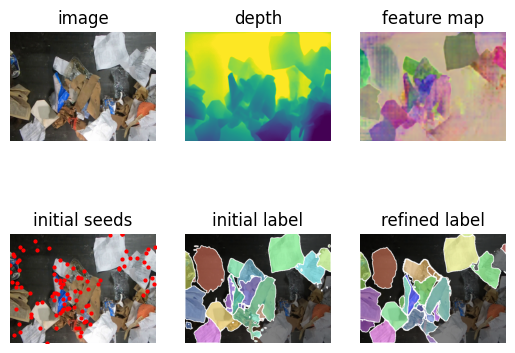

{'Objects F-measure': 0.2703850125694973, 'Objects Precision': 0.17790177345851865, 'Objects Recall': 0.5631327395177058, 'Boundary F-measure': 0.14743769095816303, 'Boundary Precision': 0.11325429127588038, 'Boundary Recall': 0.2111769686706181, 'obj_detected': 16, 'obj_detected_075': 2, 'obj_gt': 4, 'obj_detected_075_percentage': 0.5}


In [32]:
xyz_img = None

all_metrics = []
#refined_metrics = []

for i in index_images:
    if os.path.exists(images_color[i]):
        print(images_color[i])
        # read sample
        sample = read_sample(images_color[i], images_depth[i], images_gt[i], camera_params)
        # if ("new" in images_color[i]):
        #   xyz_img = sample['depth']
        # run network
        out_label, out_label_refined = test_sample(sample, network, network_crop)

        prediction = out_label.squeeze().detach().cpu().numpy()
        gt = sample["gt"].squeeze().numpy()
        metrics = multilabel_metrics(prediction, gt)
        print(metrics)

        all_metrics.append(metrics)

    else:
        print('files not exist %s' % (images_color[i]))

#print(xyz_img.shape)

## Summarize the outputs of all the images

In [23]:
obj_fmeasure = []
obj_precision = []
obj_recall = []

bound_fmeasure = []
bound_precision = []
bound_recall = []

percent_75 = []

for metric in all_metrics:
  obj_fmeasure.append(metric['Objects F-measure'])
  obj_precision.append(metric['Objects Precision'])
  obj_recall.append(metric['Objects Recall'])

  bound_fmeasure.append(metric['Boundary F-measure'])
  bound_precision.append(metric['Boundary Precision'])
  bound_recall.append(metric['Boundary Recall'])

  percent_75.append(metric['obj_detected_075_percentage'])

avg_obj_fmeasure = np.array(obj_fmeasure).sum() / len(all_metrics)
avg_obj_precision = np.array(obj_precision).sum() / len(all_metrics)
avg_obj_recall = np.array(obj_recall).sum() / len(all_metrics)

avg_bound_fmeasure = np.array(bound_fmeasure).sum() / len(all_metrics)
avg_bound_precision = np.array(bound_precision).sum() / len(all_metrics)
avg_bound_recall = np.array(bound_recall).sum() / len(all_metrics)

avg_percent_75 = np.array(percent_75).sum() / len(all_metrics)

print("Avg Obj F Measure", avg_obj_fmeasure)
print("Avg Obj Precision", avg_obj_precision)
print("Avg Obj Recall", avg_obj_recall)

print("Avg Bound F Measure", avg_bound_fmeasure)
print("Avg Bound Precision", avg_bound_precision)
print("Avg Bound Recall", avg_bound_recall)

print("Avg Percent 75:", avg_percent_75)



Avg Obj F Measure 0.6227751091915282
Avg Obj Precision 0.7656742870104224
Avg Obj Recall 0.6040217669577608
Avg Bound F Measure 0.46399002013400925
Avg Bound Precision 0.6133592067921204
Avg Bound Recall 0.4353463690476994
Avg Percent 75: 0.46591591591591586


## Pointcloud Visualization

In [45]:
import open3d as o3d

xyz_img = xyz_img.reshape(3, -1).T
print(xyz_img.shape)


xyz_img = xyz_img[::10]
print(xyz_img.shape)

torch.Size([307200, 3])
torch.Size([30720, 3])


In [28]:
cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(xyz_img)
cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

In [29]:
points = np.asarray(cloud.points)

colors = None
if cloud.has_colors():
    colors = np.asarray(cloud.colors)
elif cloud.has_normals():
    colors = (0.5, 0.5, 0.5) + np.asarray(cloud.normals) * 0.5
else:
    geometry.paint_uniform_color((1.0, 0.0, 0.0))
    colors = np.asarray(geometry.colors)

In [30]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering/data/test/data
08_frame_007100
/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering/data/test/data


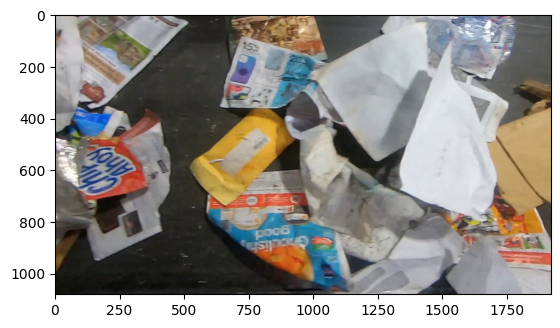

/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering/data/test/data
/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering/data/test/depth


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


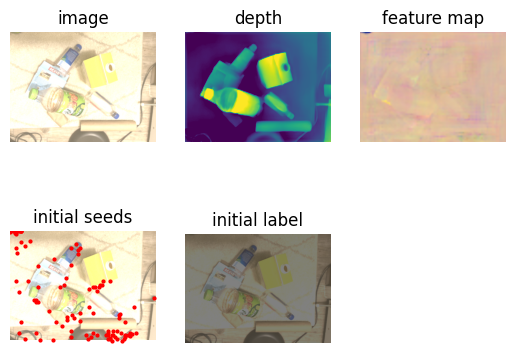

/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering/data/test/data
/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering/data/test/depth


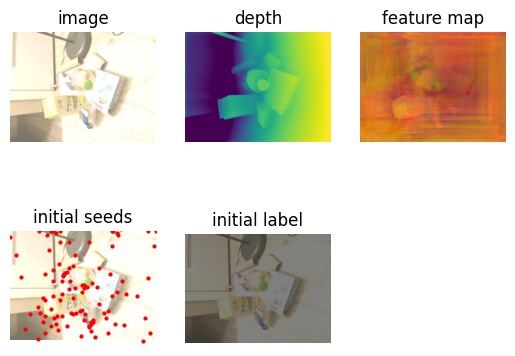

/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering/data/test/data
/content/drive/.shortcut-targets-by-id/1gjdFpKnPCCjX0XovUO8FJ7EhpPb1Bb3c/UnseenObjectClustering/data/test/depth


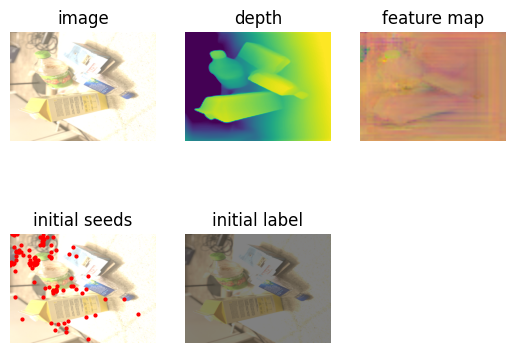

In [ ]:
from PIL import Image
sample = {}
%cd "/content/drive/My Drive/UnseenObjectClustering/data/test/data/"
full_str = f"08_frame_007100"
#full_str = f"08_frame_006700"
full_str = f"09_frame_003780"
full_str = f"09_frame_003440"
full_str = f"08_frame_005900"
full_str = f"08_frame_007100"
# full_str = f"08_frame_007400"
# full_str = f"08_frame_005900"
# full_str = f"09_frame_003700"
# full_str = f"09_frame_003780"

print(full_str)
image = Image.open(f"{full_str}.PNG").convert("RGB")
#image = Image.open(f"09_frame_003920.PNG")#.convert("RGB")

from matplotlib import pyplot as plt
%cd "/content/drive/My Drive/UnseenObjectClustering/data/test/data/"

# file_1 = "01_frame_000680.PNG"
# file_2 = "01_frame_000690.PNG"
# im_1 = Image.open("01_frame_000680.PNG")
# im_1.show()
# im_2 = Image.open("01_frame_000690.PNG")
# im_2.show()

plt.imshow(image)
plt.show()

image.show()
image = image.resize((480, 640))
file_names = [f"09_frame_003780", f"09_frame_003440", f"08_frame_005900", f"08_frame_007100", f"08_frame_007400", f"08_frame_005900", f"09_frame_003700", f"09_frame_003780"]
file_names = ["IMG_5805", "IMG_5806", "IMG_5807"]
for full_str in file_names:
  sample = {}
  %cd "/content/drive/My Drive/UnseenObjectClustering/data/test/data/"  
  image = Image.open(f"{full_str}.png").convert("RGB")
  image = image.resize((480, 640))
  %cd "/content/drive/My Drive/UnseenObjectClustering/data/test/depth/"
  depth = Image.open(f"{full_str}_col.PNG").convert("RGB") 
  depth = depth.resize((480, 640))
  im_np = (np.asarray(image))/255 
  im_np = im_np[:,:,::-1]

  #color: rgb(140 / 255, 180 / 255, 205 / 255)

  #normalized = (im_np-np.min(im_np))/(np.max(im_np)-np.min(im_np))/255
  sample['image_color'] = torch.tensor(im_np.copy(), dtype=torch.float)
  sample['image_color'] = sample['image_color'].permute(2, 1, 0)
  sample['image_color'] = sample['image_color'][None, :, :, :]

  sample['depth'] = torch.tensor(np.asarray(depth), dtype=torch.float)
  sample['depth'] = sample['depth'].permute(2, 1, 0)
  sample['depth'] = sample['depth'][None, :, :, :]
  

  test_sample(sample, network, network_crop)